# Classifying German Press Releases using GBERT


This script is based on a tutorial by Philipp Schmid (2020) that can be found [here](https://towardsdatascience.com/bert-text-classification-in-a-different-language-6af54930f9cb).

The script uses [Simple Transformers](https://github.com/ThilinaRajapakse/simpletransformers) - an NLP library based on the [Transformers](https://github.com/huggingface/transformers) library by HuggingFace.

Specifically, we use the pretrained German BERT language model that can be downloaded from the HuggingFace model hub under the title "deepset/gbert-base" [(Chan, Schweter and Möller 2020)](https://arxiv.org/pdf/2010.10906.pdf). It was trained using the OPUS and Wikipedia corpora and has been shown to provide optimal performance.

After fine-tuning the model, we achieved an average accuracy of 77.4% in a five-fold cross-validation. This constitutes a substantial improvement compared to other models.

### We are going to

- install Simple Transformers library
- select a pre-trained model
- load the dataset
- train/fine-tune the model
- evaluate the results of it
- do a cross-validation
- test the accuracy for smaller training datasets


# Install Simple Transformers library 

In [ ]:
# install simpletransformers
!pip install simpletransformers

# check installed version
!pip freeze | grep simpletransformers
# simpletransformers==0.28.2

simpletransformers==0.61.13


# Load packages

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from google.colab import drive
import os
import pandas as pd
from simpletransformers.classification import ClassificationModel
import os
import tarfile
from shutil import copyfile
from random import randrange
import torch
import gc
from sklearn.metrics import accuracy_score
import timeit
import numpy as np

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

# Load the dataset

In [ ]:
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/scripts-hu/issues/transfer-files')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv('alldocs.csv') 
print(df.columns)
df.shape

Index(['issue_r1', 'id', 'country', 'party', 'date', 'cv_sample', 'htext',
       'label'],
      dtype='object')


(44950, 8)

# Five-fold cross-validation

In order to test the robustness of our results to different compoisitions of our training and test data, we fine-tune the model on five different sets and evaluate the performance.

In [ ]:
# Prepare five-fold cross-validation

# With threshold
# Define hyperparameter
train_args = {
    'reprocess_input_data': True,
    'train_batch_size': 16, 
    'num_train_epochs': 4, 
    'max_seq_length': 512, 
    'save_steps': 500000, 
    'overwrite_output_dir': True,
    'fp16': False,
    'manual_seed': 1621447882,
}

# Create a list to store the data of each fold
results = []
times = []
bert_pred = pd.DataFrame()

# Loop over all folds (5)
for i in [1, 2, 3, 4, 5]:
  print(i)

  # Empty memory
  torch.cuda.empty_cache() 
  gc.collect()

  # Create train/test df
  train_df = df[(df.cv_sample != i) & (df.issue_r1!= -1)][['htext','label']]
  print('train shape: ', train_df.shape)
  
  test_df = df[(df.cv_sample == i) & (df.issue_r1!= -1)][['htext','label']]
  print('test shape: ', test_df.shape)
  
  # Create a ClassificationModel
  model = ClassificationModel(
    "bert", "deepset/gbert-base",
    num_labels= 17,
    use_cuda = True,
    args=train_args
  )
  
  start = timeit.default_timer()

  # Train the model
  model.train_model(train_df)

  # Add the time to the list
  stop = timeit.default_timer()
  times.append((stop - start))

  # Run the evaluation on the test set
  result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=accuracy_score)
  
  print(result['acc'])
  
  # Add the accuracy to the list
  results.append(result['acc'])

  predictions, raw_outputs = model.predict([item for sublist in test_df[['htext']].values.tolist() for item in sublist])

  this_bert_pred = pd.DataFrame({'prediction': predictions,
                                 'issue_r1': np.concatenate(df[(df.cv_sample == i) & (df.issue_r1!= -1)][['issue_r1']].values),
                                 'label': np.concatenate(df[(df.cv_sample == i) & (df.issue_r1!= -1)][['label']].values),
                                 'cv_sample': i},
                                index = list(range(0, len(test_df))))
  print(this_bert_pred)

  bert_pred = bert_pred.append(this_bert_pred)
                   
  np.savetxt("bert-pred.csv", bert_pred, delimiter = ",")


1
train shape:  (2098, 2)
test shape:  (514, 2)


KeyboardInterrupt: ignored

The average accuracy is:

In [ ]:
print(f'Average accuracy: {sum(results)/5}')

In [ ]:
np.savetxt("cv-accuracy.txt", [sum(results)/5], delimiter = ",")
np.savetxt("cv-time.txt", [sum(times)/5], delimiter = ",")

# Size of training data

In [ ]:
train_df = df[(df.cv_sample != i) & (df.issue_r1!= -1)][['htext','label']]
train_df[:2095].shape

(2095, 2)

In [ ]:
testsizes = [5, 25, 50, 100, 200, 300, 400, 500, 600, 700, 1000, 1500, 1750, 2000, 2095]

In [ ]:
# define hyperparameter
train_args = {
    'reprocess_input_data': True,
    'train_batch_size': 16, 
    'num_train_epochs': 4,
    'max_seq_length': 512, 
    'save_steps': 500000, 
    'overwrite_output_dir': True,
    'fp16': False,
    'manual_seed': 1621447882,
}


# Create a list to store the accuracy of each iteration
results = []

# Loop over all sizes
for k in testsizes:
  print(k)

  # Empty memory
  #torch.cuda.empty_cache() 
  #gc.collect()
  
  i = 5 # Select fold (Folds are pre-defined in the dataset)
  
  # Create train/test df
  train_df = df[(df.cv_sample != i) & (df.issue_r1!= -1)][['htext','label']]
  test_df = df[(df.cv_sample == i) & (df.issue_r1!= -1)][['htext','label']]

  # Reduce size of train_df
  train_df = train_df[:k]

  print(train_df.shape)

  # Create a ClassificationModel
  model = ClassificationModel(
    "bert", "deepset/gbert-base",
    num_labels= 17,
    use_cuda = True,
    args=train_args
  )
  
  # Train the model
  model.train_model(train_df)
  
  # Run the evaluation on the test set
  predictions, raw_outputs = model.predict([item for sublist in test_df[['htext']].values.tolist() for item in sublist])
  # result, model_outputs, wrong_predictions = model.eval_model(test_df, acc=accuracy_score)

  print(accuracy_score(predictions, test_df[['label']]))
  
  # Add the accuracy to the list
  # results.append(result['acc'])
  results.append(accuracy_score(predictions, test_df[['label']]))
  

2095
(2095, 2)


Some weights of the model checkpoint at deepset/gbert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

  0%|          | 0/2095 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/131 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/131 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/131 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

0.793036750483559


In [ ]:
results

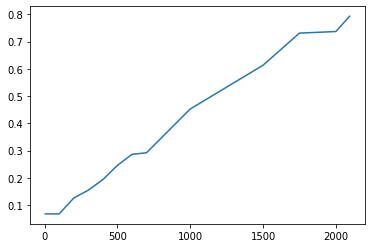

In [ ]:
import matplotlib.pyplot as plt
plt.plot(testsizes, results)

In [ ]:
results = pd.DataFrame({'accuracy': results, 'size': testsizes})
print(results)

    accuracy  size
0   0.067698     5
1   0.067698    25
2   0.067698    50
3   0.067698   100
4   0.125725   200
5   0.154739   300
6   0.193424   400
7   0.245648   500
8   0.286267   600
9   0.292070   700
10  0.452611  1000
11  0.613153  1500
12  0.731141  1750
13  0.736944  2000
14  0.793037  2095


In [ ]:
np.savetxt("results-training-size.csv", results, delimiter = ",")

# Classify unlabeled data
## Load and train model

In [ ]:
# Create train (all labeled)
train_df = df[df.issue_r1!= -1][['htext','label']]
print('train shape: ', train_df.shape)


train shape:  (2612, 2)


In [ ]:
# Define hyperparameters
train_args = {
    'reprocess_input_data': True,
    'train_batch_size': 16, 
    'num_train_epochs': 4, 
    'max_seq_length': 512, 
    'save_steps': 500000, 
    'overwrite_output_dir': True,
    'fp16': False,
    'manual_seed': 1621447882,
}


# Create a ClassificationModel
model = ClassificationModel(
    "bert", "deepset/gbert-base",
    num_labels= 17,
    use_cuda = True,
    args=train_args
)

# Train the model
model.train_model(train_df)

Some weights of the model checkpoint at deepset/gbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

  0%|          | 0/2612 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/164 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/164 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/164 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/164 [00:00<?, ?it/s]

(656, 0.7609783815242713)

## Save and load the model

Save files in folder "outputs".


In [ ]:
# Save and pack model
def save_model(model_path='',file_name=''):
  files = [files for root, dirs, files in os.walk(model_path)][0]
  with tarfile.open(file_name+ '.tar.gz', 'w:gz') as f:
    for file in files:
      f.add(f'{model_path}/{file}')
  f.close()

In [ ]:
save_model('outputs','gbert-scripts-issues-german')

In [ ]:
# !tar -zxvf ../transfer-files/germeval-distilbert-german.tar.gz

## Examples for classification

We present a press release and the predicted label. Some examples should be misclassified. Note, however, that these misclassifications often still make some sense.

In [ ]:

# These are our class labels.
# Note that the labels range from 0 to 16 and therefore differ from the CAP labels in the dataset.
class_list = ['MACROECONOMICS', 'CIVIL RIGHTS', 'HEALTH', 'AGRICULTURE','LABOR', 'EDUCATION', 
              'ENVIRONMENT AND ENERGY', 'IMMIGRATION', 'WELFARE', 'LAW AND CRIME', 'COMMERCE', 
              'DEFENSE', 'TECHNOLOGY', 'GOVERNMENT OPS', 'OTHER', 'INTERNATIONAL AFFAIRS', 'EUROPEAN UNION']

# Example
sampledoc = randrange(test_df.shape[0])
test_tweet = test_df["htext"].iloc[sampledoc]
test_label = test_df["label"].iloc[sampledoc]
predictions, raw_outputs = model.predict([test_tweet])
print(test_tweet)
print(f"Prediction: {class_list[predictions[0]]}; Truth: {class_list[test_label]}")


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Terror kann man nicht mit Krieg bekämpfen „Deutschland darf sich nicht zum Erfüllungsgehilfen der US-Außenpolitik machen und muss die von Ashton Carter geforderte Beteiligung der NATO im Kampf gegen den IS strikt ablehnen“, erklärt Alexander S. Neu, Obmann im Verteidigungsausschuss für die Fraktion Die LINKE, anlässlich des heutigen Treffens der Verteidigungsminister in Stuttgart. Neu weiter:„Die USA drängen schon lange auf mehr militärisches Engagement der ‚Anti IS Koalition‘. Nun brachte US-Verteidigungsminister Carter erneut eine Beteiligung der NATO sowie den Einsatz von Awacs-Aufklärungsflugzeugen ins Spiel. Sollte dies Realität werden, begibt sich die NATO – und damit auch Deutschland – in einen langen, blutigen und völlig aussichtslosen Krieg gegen den IS. Statt sich am Krieg zu beteiligen und ihn damit weiter zu verschärfen, sollte sich Deutschland intensiv für die Bekämpfung der Ursachen einsetzen, welchen zum Erstarken des IS geführt haben. Dazu gehört unter anderem, eine Lös

## Load the model

In [ ]:
# Unpack model
def unpack_model(model_name=''): 
  tar = tarfile.open(f"{model_name}.tar.gz", "r:gz")
  tar.extractall()
  tar.close()

unpack_model('gbert-scripts-issues-german')

In [ ]:
# define hyperparameter
train_args = {
    'reprocess_input_data': True,
    'train_batch_size': 16, 
    'num_train_epochs': 4, 
    'max_seq_length': 512, 
    'save_steps': 500000, 
    'overwrite_output_dir': True,
    'fp16': False,
    'manual_seed': 1621447882,
}

# Create a ClassificationModel
model = ClassificationModel(
    "bert", "outputs/",
    num_labels= 17,
    use_cuda = True,
    args=train_args
)

## Predict all labels

In [ ]:
  predictions, raw_outputs = model.predict([item for sublist in df[['htext']].values.tolist() for item in sublist])

  0%|          | 0/44950 [00:00<?, ?it/s]

  0%|          | 0/5619 [00:00<?, ?it/s]

In [ ]:
unlabeled_pred = pd.DataFrame({'prediction': predictions,
                                 'id': np.concatenate(df[['id']].values)},
                                index = list(range(0, len(predictions))))

In [ ]:
  np.savetxt("alldocs-pred.csv", unlabeled_pred, delimiter = ",")